In [1]:
from os.path import join
import sys
import numpy as np

In [2]:
LOAD_DIR = '/dtu/projects/02613_2025/data/modified_swiss_dwellings/'
with open(join(LOAD_DIR, 'building_ids.txt'), 'r') as f:
    building_ids = f.read().splitlines()
    print(f'Loaded {len(building_ids)} building ids')
    print(f'Building ids: {building_ids}')

Loaded 4571 building ids
Building ids: ['10000', '10009', '10014', '10019', '10029', '10031', '10051', '10053', '10056', '10064', '10075', '10079', '10080', '10082', '10083', '10084', '10085', '10086', '10087', '10089', '10090', '10093', '10094', '10097', '10117', '10119', '10120', '10124', '10126', '10128', '10136', '10144', '10145', '10150', '10161', '10165', '10167', '10168', '10174', '10176', '10177', '10180', '10182', '10198', '10199', '10200', '10201', '10202', '10203', '10204', '10205', '10206', '10207', '10208', '1021', '10215', '10219', '1022', '1023', '1024', '10243', '10244', '10245', '10247', '10249', '1025', '10251', '10252', '10255', '10257', '10259', '1026', '10260', '10262', '10263', '10265', '10267', '10268', '10269', '1027', '10276', '10277', '10279', '10281', '10282', '10285', '10288', '10291', '10292', '10303', '10306', '1031', '10311', '10312', '10315', '10316', '10318', '10323', '10324', '10330', '10334', '10337', '10340', '10349', '10350', '10354', '10356', '1035

In [3]:
def load_data(load_dir, bid):
    SIZE = 512
    u = np.zeros((SIZE + 2, SIZE + 2))
    u[1:-1, 1:-1] = np.load(join(load_dir, f"{bid}_domain.npy"))
    interior_mask = np.load(join(load_dir, f"{bid}_interior.npy"))
    return u, interior_mask


def jacobi(u, interior_mask, max_iter, atol=1e-6):
    u = np.copy(u)

    for i in range(max_iter):
        # Compute average of left, right, up and down neighbors, see eq. (1)
        u_new = 0.25 * (u[1:-1, :-2] + u[1:-1, 2:] + u[:-2, 1:-1] + u[2:, 1:-1])
        u_new_interior = u_new[interior_mask]
        delta = np.abs(u[1:-1, 1:-1][interior_mask] - u_new_interior).max()
        u[1:-1, 1:-1][interior_mask] = u_new_interior

        if delta < atol:
            break
    return u


def summary_stats(u, interior_mask):
    u_interior = u[1:-1, 1:-1][interior_mask]
    mean_temp = u_interior.mean()
    std_temp = u_interior.std()
    pct_above_18 = np.sum(u_interior > 18) / u_interior.size * 100
    pct_below_15 = np.sum(u_interior < 15) / u_interior.size * 100
    return {
        'mean_temp': mean_temp,
        'std_temp': std_temp,
        'pct_above_18': pct_above_18,
        'pct_below_15': pct_below_15,
    }


In [5]:
# Load data
LOAD_DIR = '/dtu/projects/02613_2025/data/modified_swiss_dwellings/'
with open(join(LOAD_DIR, 'building_ids.txt'), 'r') as f:
    building_ids = f.read().splitlines()

N = 10
building_ids = building_ids[:N]

# Load floor plans
all_u0 = np.empty((N, 514, 514))
all_interior_mask = np.empty((N, 512, 512), dtype='bool')
for i, bid in enumerate(building_ids):
    u0, interior_mask = load_data(LOAD_DIR, bid)
    all_u0[i] = u0
    all_interior_mask[i] = interior_mask

# Run jacobi iterations for each floor plan
MAX_ITER = 20_000
ABS_TOL = 1e-4

all_u = np.empty_like(all_u0)
for i, (u0, interior_mask) in enumerate(zip(all_u0, all_interior_mask)):
    u = jacobi(u0, interior_mask, MAX_ITER, ABS_TOL)
    all_u[i] = u

# Print summary statistics in CSV format
stat_keys = ['mean_temp', 'std_temp', 'pct_above_18', 'pct_below_15']
print('building_id, ' + ', '.join(stat_keys))  # CSV header
for bid, u, interior_mask in zip(building_ids, all_u, all_interior_mask):
    stats = summary_stats(u, interior_mask)
    print(f"{bid},", ", ".join(str(stats[k]) for k in stat_keys))

building_id, mean_temp, std_temp, pct_above_18, pct_below_15
10000, 14.01233878811275, 6.367431059312565, 30.941014791508444, 55.542295034537624
10009, 11.000135812436373, 5.811144379826625, 16.6712734948236, 74.9723590310584
10014, 14.744169941950119, 7.037733284673848, 38.26367541377415, 52.80837116508215
10019, 14.735524480624482, 7.030325006703675, 38.14915412864569, 52.92926826787113
10029, 10.616037322820358, 6.317331938274926, 18.25563221896085, 74.51301795448481
10031, 12.507072852890545, 6.278432089100354, 24.044722033998173, 66.39513301711693
10051, 13.289039951277402, 5.999085063388632, 25.97693550756574, 62.859923608050536
10053, 11.366493551285709, 6.26121798185875, 19.9510754583921, 72.41052538787024
10056, 14.220114507861702, 6.179461157398302, 31.763454814173965, 57.06174975667784
10064, 12.71696893739585, 6.964227784263683, 28.79137124461432, 62.75688345539249


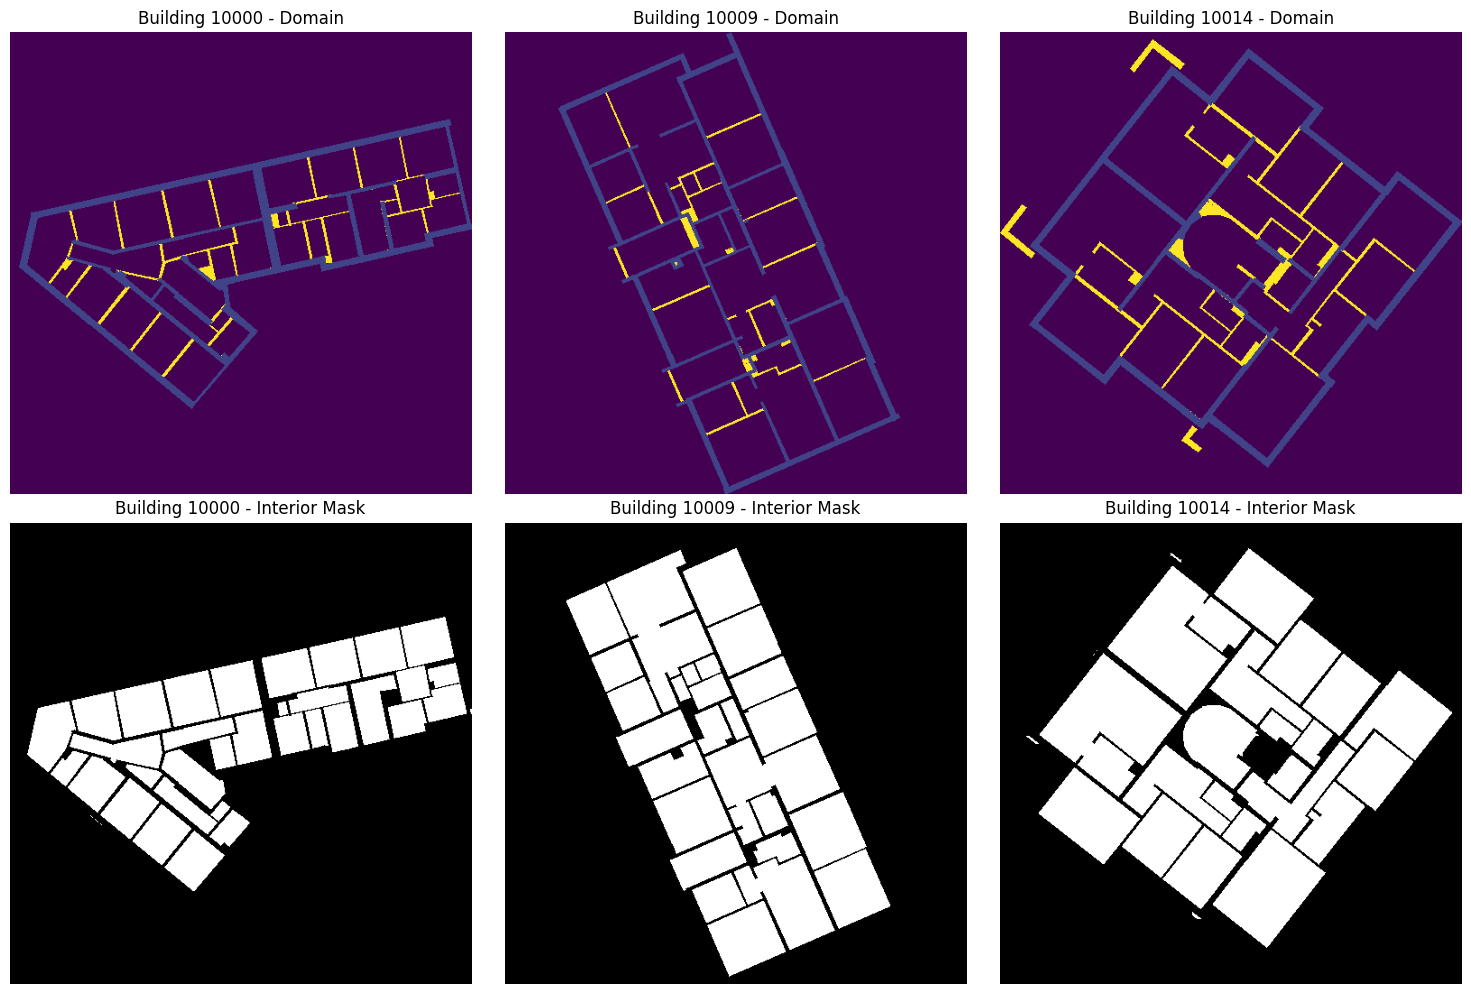

In [6]:
import matplotlib.pyplot as plt

# Function to visualize the domain and interior mask
def visualize_floorplans(building_ids, load_dir, num_plans=3):
    fig, axes = plt.subplots(2, num_plans, figsize=(5 * num_plans, 10))
    for i, bid in enumerate(building_ids[:num_plans]):
        # Load domain and interior mask
        domain = np.load(join(load_dir, f"{bid}_domain.npy"))
        interior = np.load(join(load_dir, f"{bid}_interior.npy"))
        
        # Plot domain
        axes[0, i].imshow(domain, cmap='viridis')
        axes[0, i].set_title(f"Building {bid} - Domain")
        axes[0, i].axis('off')
        
        # Plot interior mask
        axes[1, i].imshow(interior, cmap='gray')
        axes[1, i].set_title(f"Building {bid} - Interior Mask")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the first few floorplans
visualize_floorplans(building_ids, LOAD_DIR, num_plans=3)

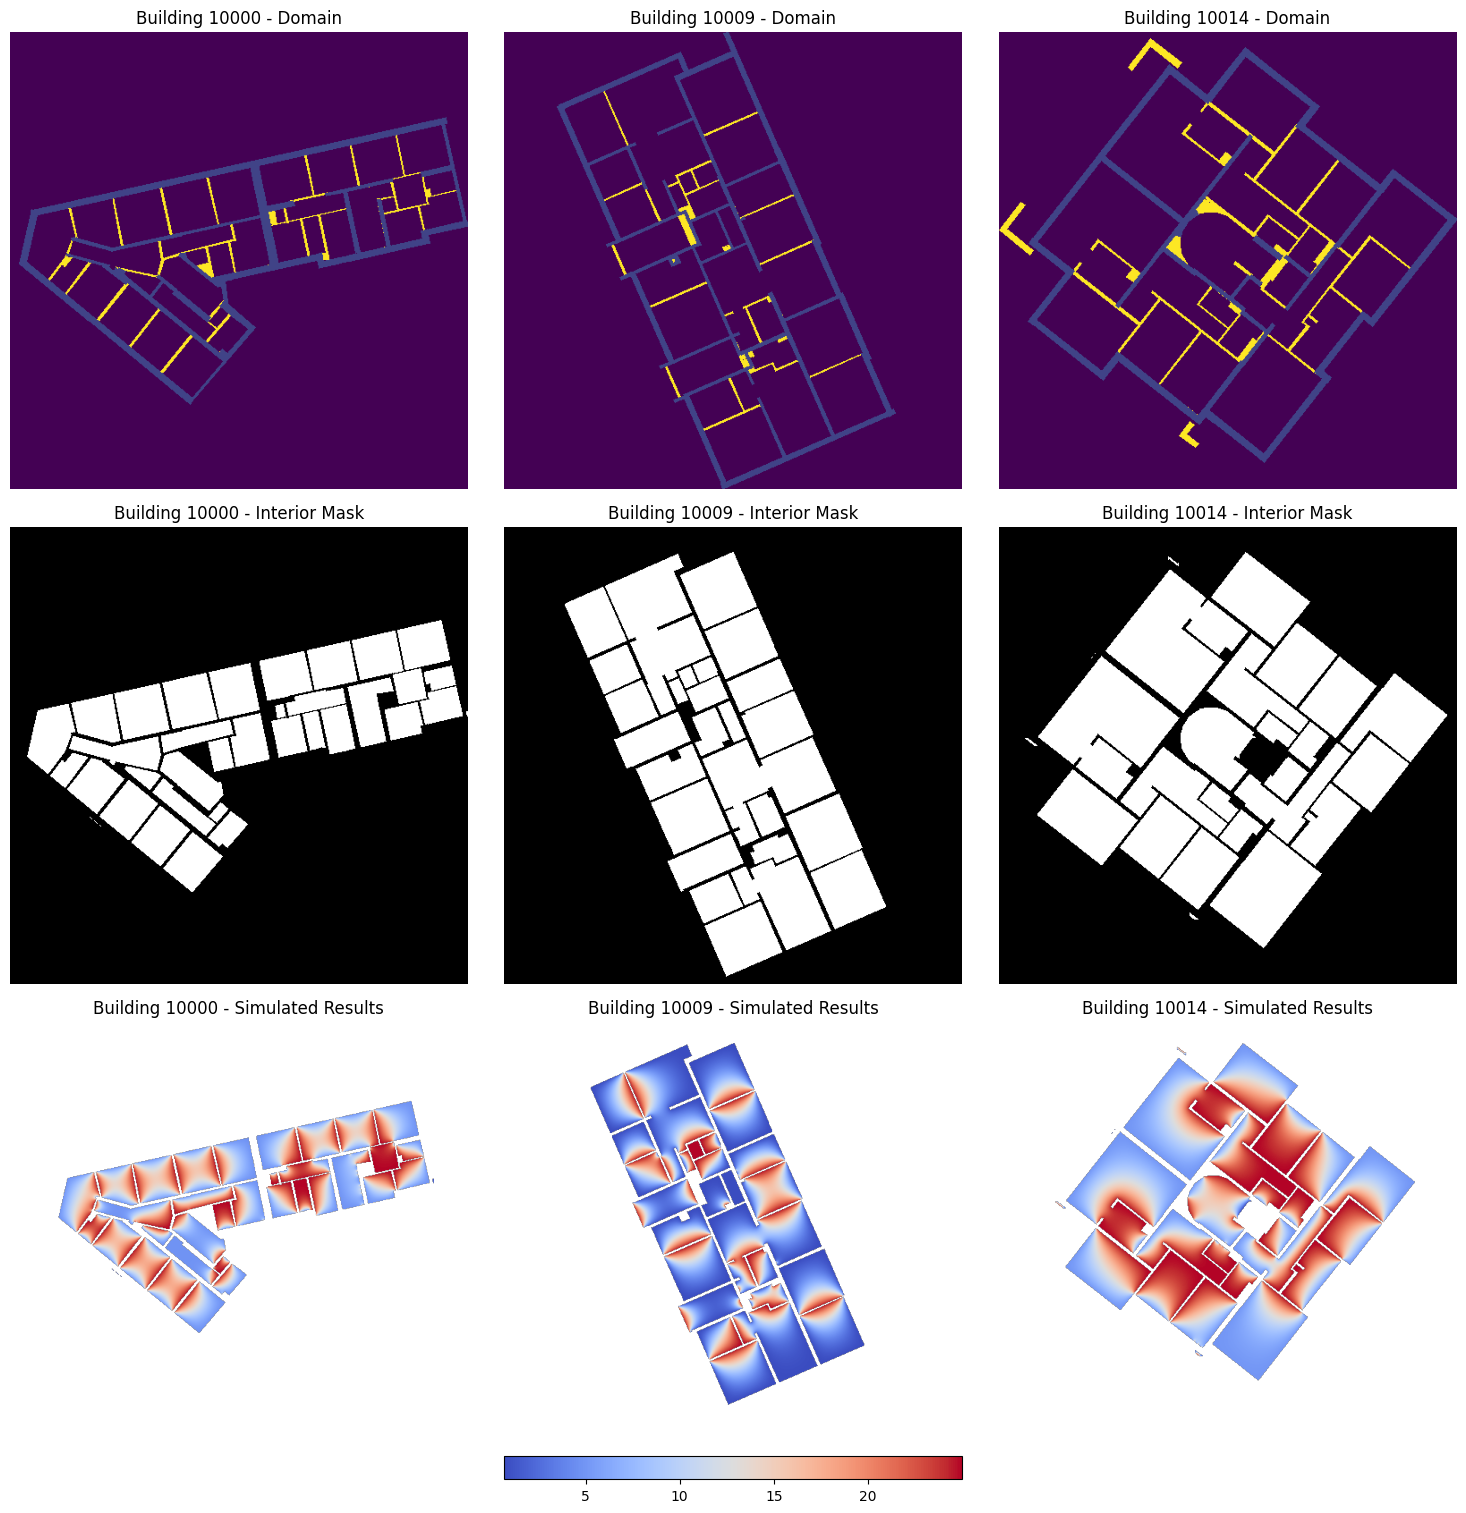

In [7]:
def visualize_simulation_results(building_ids, all_u, all_interior_mask, num_plans=3):
    fig, axes = plt.subplots(3, num_plans, figsize=(5 * num_plans, 15))
    for i, bid in enumerate(building_ids[:num_plans]):
        # Load domain and interior mask
        domain = np.load(join(LOAD_DIR, f"{bid}_domain.npy"))
        interior = np.load(join(LOAD_DIR, f"{bid}_interior.npy"))
        simulated_u = all_u[i, 1:-1, 1:-1]  # Exclude ghost cells
        mask = all_interior_mask[i]

        # Plot domain
        axes[0, i].imshow(domain, cmap='viridis')
        axes[0, i].set_title(f"Building {bid} - Domain")
        axes[0, i].axis('off')

        # Plot interior mask
        axes[1, i].imshow(interior, cmap='gray')
        axes[1, i].set_title(f"Building {bid} - Interior Mask")
        axes[1, i].axis('off')

        # Plot simulated results
        simulated_display = np.full_like(simulated_u, np.nan)
        simulated_display[mask] = simulated_u[mask]
        im = axes[2, i].imshow(simulated_display, cmap='coolwarm', vmin=simulated_u[mask].min(), vmax=simulated_u[mask].max())
        axes[2, i].set_title(f"Building {bid} - Simulated Results")
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.colorbar(im, ax=axes[2, :], orientation='horizontal', fraction=0.05, pad=0.1)
    plt.show()

# Visualize the first few simulation results
visualize_simulation_results(building_ids, all_u, all_interior_mask, num_plans=3)

kernprof -l simulate.py

Timer unit: 1e-06 s

Total time: 3.3186 s
File: simulate.py
Function: jacobi at line 14

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    14                                           @profile
    15                                           def jacobi(u, interior_mask, max_iter, atol=1e-6):
    16         1        826.3    826.3      0.0      u = np.copy(u)
    17                                           
    18      3602        891.1      0.2      0.0      for i in range(max_iter):
    19                                                   # Compute average of left, right, up and down neighbors, see eq. (1)
    20      3602    1870860.6    519.4     56.4          u_new = 0.25 * (u[1:-1, :-2] + u[1:-1, 2:] + u[:-2, 1:-1] + u[2:, 1:-1])
    21      3602     430312.9    119.5     13.0          u_new_interior = u_new[interior_mask]
    22      3602     620633.9    172.3     18.7          delta = np.abs(u[1:-1, 1:-1][interior_mask] - u_new_interior).max()
    23      3602     393229.4    109.2     11.8          u[1:-1, 1:-1][interior_mask] = u_new_interior
    24                                           
    25      3602       1843.7      0.5      0.1          if delta < atol:
    26         1          0.7      0.7      0.0              break
    27         1          0.2      0.2      0.0      return u

  3.32 seconds - simulate.py:14 - jacobi

### Profiling Results for the `jacobi` Function

The `jacobi` function is responsible for performing iterative updates on a 2D array `u` using the Jacobi method. Below is a breakdown of the function's key parts and their respective execution times based on the profiling results:

1. **Copying the Input Array (`u`)**  
    - **Line 16**: `u = np.copy(u)`  
      This creates a copy of the input array `u` to avoid modifying the original data.  
      - **Hits**: 1  
      - **Time**: 826.3 µs  
      - **% Time**: 0.0%  

2. **Jacobi Iteration Loop**  
    - **Line 18**: `for i in range(max_iter):`  
      This loop runs for a maximum of `max_iter` iterations or until convergence is achieved.  
      - **Hits**: 3602 iterations  

    - **Line 20**: Compute the average of neighboring cells:  
      ```python
      u_new = 0.25 * (u[1:-1, :-2] + u[1:-1, 2:] + u[:-2, 1:-1] + u[2:, 1:-1])
      ```  
      This is the most time-consuming part of the function, as it involves array slicing and arithmetic operations.  
      - **Time**: 1,870,860.6 µs  
      - **% Time**: 56.4%  

    - **Line 21**: Extract interior values:  
      ```python
      u_new_interior = u_new[interior_mask]
      ```  
      This step applies the `interior_mask` to filter relevant values.  
      - **Time**: 430,312.9 µs  
      - **% Time**: 13.0%  

    - **Line 22**: Compute the maximum difference (`delta`):  
      ```python
      delta = np.abs(u[1:-1, 1:-1][interior_mask] - u_new_interior).max()
      ```  
      This checks for convergence by calculating the maximum absolute difference.  
      - **Time**: 620,633.9 µs  
      - **% Time**: 18.7%  

    - **Line 23**: Update the interior values of `u`:  
      ```python
      u[1:-1, 1:-1][interior_mask] = u_new_interior
      ```  
      This updates the array `u` with the new values for the next iteration.  
      - **Time**: 393,229.4 µs  
      - **% Time**: 11.8%  

    - **Line 25**: Check for convergence:  
      ```python
      if delta < atol:
            break
      ```  
      If the maximum difference is below the tolerance (`atol`), the loop exits early.  
      - **Time**: 1,843.7 µs  
      - **% Time**: 0.1%  

3. **Return the Updated Array (`u`)**  
    - **Line 27**: `return u`  
      Returns the final updated array after convergence or reaching the maximum number of iterations.  
      - **Hits**: 1  
      - **Time**: 0.7 µs  
      - **% Time**: 0.0%  

### Summary of Execution Times
- **Total Time**: 3.32 seconds  
- **Most Time-Consuming Part**: Line 20 (56.4%) - Computing the average of neighboring cells.  
- **Least Time-Consuming Part**: Line 27 (0.0%) - Returning the result.